In [2]:
from dataset import *
from evaluator import *
from torch.utils.data import DataLoader

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.autograd as autograd
from torchsummary import summary

from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

import tqdm

path = "./Auxiliary_DCGAN_with_pretrained_"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [3]:
image_size = 64

trans = transforms.Compose([transforms.ToPILImage(),
                            transforms.Resize([image_size, image_size]),
                            transforms.CenterCrop([image_size, image_size]),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5)), # normalize to [-1, 1] for the last layer of generator is tanh()
                            ])

# preprocessing size -> 64x64
train = ICLEVRLoader("./", trans=trans, mode="train", preprocessing=None)
# test = ICLEVRLoader("./", mode="test")

batch_size = 128 # based on paper
train_loader = DataLoader(
    dataset=train, 
    batch_size=batch_size,
    num_workers = 4
)

data = json.load(open(os.path.join('./','test.json')))
obj = json.load(open(os.path.join('./','objects.json')))
test_labels = data
for i in range(len(test_labels)):
    for j in range(len(test_labels[i])):
        test_labels[i][j] = obj[test_labels[i][j]]
    tmp = np.zeros(len(obj))
    tmp[test_labels[i]] = 1
    test_labels[i] = tmp
test_labels = torch.tensor(test_labels).to(device)

> Found 18009 images...


In [4]:
class Generator(nn.Module):
    def __init__(self, n_classes, latent_dim, img_shape, n_channels):
        super(Generator, self).__init__()
        
        self.n_classes = n_classes
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.input_cnn = nn.Linear(n_classes+latent_dim, 128)

        self.main = nn.Sequential(
            # input is Z, going into a convolution
#             nn.ConvTranspose2d( img_shape, img_shape*8 , 4, 1, 0, bias=False), #input shape [batch_size, 64, 1, 1]
            nn.ConvTranspose2d( 128, img_shape*8 , 4, 1, 0, bias=False), # input shape [batch_size, 64, 2, 2]
            nn.BatchNorm2d(img_shape*8),
            nn.ReLU(True),
            # state size. (img_shape*8) x 4 x 4
            nn.ConvTranspose2d(img_shape * 8, img_shape * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 4),
            nn.ReLU(True),
            # state size. (img_shape*4) x 8 x 8
            nn.ConvTranspose2d( img_shape * 4, img_shape * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 2),
            nn.ReLU(True),
            # state size. (img_shape*2) x 16 x 16
            nn.ConvTranspose2d( img_shape * 2, img_shape, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape),
            nn.ReLU(True),
            # state size. (img_shape) x 32 x 32
            nn.ConvTranspose2d( img_shape, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels) x 64 x 64
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((labels, noise), -1).float()
        gen_input = self.input_cnn(gen_input).view(-1, 128, 1, 1)
        img = self.main(gen_input)
        return img


class Discriminator(nn.Module):
    def __init__(self, n_classes, img_shape):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.img_shape= img_shape
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        
        self.label_linear = nn.Linear(n_classes, img_shape*img_shape)        
        
        self.main = nn.Sequential(
            # input is (n_classes) x 64 x 64
            nn.Conv2d(3, img_shape, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape) x 32 x 32
            nn.Conv2d(img_shape, img_shape * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(img_shape * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*2) x 16 x 16
            nn.Conv2d(img_shape * 2, img_shape * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(img_shape * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*4) x 8 x 8
            nn.Conv2d(img_shape * 4, img_shape * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(img_shape * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*8) x 4 x 4
#             nn.Conv2d(img_shape * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
        )
        
        # Output layers
        self.adv_layer = nn.Sequential(
            nn.Conv2d(img_shape * 8, 1, 4, 1, 0, bias=False), 
#             nn.Sigmoid()
        )
        self.aux_layer = nn.Sequential(
            nn.Linear(img_shape * 8 * 4 * 4, self.n_classes), 
            nn.Sigmoid()
        )

    def forward(self, img):
        # Concatenate label embedding and image to produce input
#         labels = self.label_linear(labels.float()).view(-1, 1, self.img_shape, self.img_shape)
#         d_in = torch.cat((img, labels), 1)
        out = self.main(img)

        validity = self.adv_layer(out).view(-1, 1)
        label = self.aux_layer(out.view(out.shape[0], -1))

        return validity, label

In [14]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# loss function
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.BCELoss()

# model 
n_classes = 24
latent_dim = 100
img_shape = 64
n_channels = 3
load = False
if load:
    generator = torch.load(path+"generator.pt", map_location=device)
    discriminator = torch.load(path+"discriminator.pt", map_location=device)
    
     
    discriminator.adv_layer = nn.Sequential(
                                    nn.Conv2d(img_shape * 8, 1, 4, 1, 0, bias=False), 
                                    nn.Sigmoid()
                                )
    
    discriminator.aux_layer =  nn.Sequential(
                                    nn.Linear(img_shape * 8 * 4 * 4, 24), 
                                    nn.Sigmoid()
                                )
    discriminator = discriminator.to(device)
    print(discriminator)
    summary(discriminator)
else:
    generator = Generator(n_classes, latent_dim, img_shape, n_channels).to(device)
    discriminator = Discriminator(n_classes, img_shape).to(device)
#     print(discriminator)
    summary(discriminator, (3, 64, 64))
#     print(generator)
    summary(generator, input_data=[(1, 100), (1, 24)])
    generator.apply(weights_init)
    discriminator.apply(weights_init)

# optimizer 
lr = 0.0002
b1 = 0.5
b2 = 0.999
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 4, 4]           --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─LeakyReLU: 2-4                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-5                       [-1, 256, 8, 8]           524,288
|    └─LeakyReLU: 2-6                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-7                       [-1, 512, 4, 4]           2,097,152
|    └─LeakyReLU: 2-8                    [-1, 512, 4, 4]           --
├─Sequential: 1-2                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-9                       [-1, 1, 1, 1]             8,192
├─Sequential: 1-3                        [-1, 24]                  --
|    └─Linear: 2-10                      [-1, 24]             

In [5]:
def save_acc(filename, g_loss, d_loss):
    try:
        acc = np.load(filename)
        np_g_loss = acc['g_loss']
        np_d_loss = acc['d_loss']
        np_g_loss = np.append(np_g_loss, g_loss)
        np_d_loss = np.append(np_d_loss, d_loss)
        np.savez(filename, g_loss=np_g_loss, d_loss=np_d_loss)
    except:
        g_loss = np.array(g_loss)
        d_loss = np.array(d_loss)
        np.savez(filename, g_loss=g_loss, d_loss=d_loss)
        
def test_eval(generator, epoch):
    generator.eval()
    eval_model = evaluation_model()
    batch_size = test_labels.shape[0]
    z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device) # shape [batch_size, latent_dim] with normal distribution
    gen_imgs = generator(z, test_labels) # shape [batch_size, 3, 64, 64]
    if epoch % 10 == 0:
        show_image(gen_imgs)
    return eval_model.eval(gen_imgs, test_labels)

def show_image(gen_imgs):
    # step 1: convert it to [0 ,2]
    gen_imgs = gen_imgs +1
    
    # step 2: convert it to [0 ,1]
    gen_imgs = gen_imgs - gen_imgs.min()
    gen_imgs = gen_imgs / (gen_imgs.max() - gen_imgs.min())
    
    grid = make_grid(gen_imgs)
    plt.figure(figsize=(14, 14))
    plt.imshow(np.transpose(grid.detach().cpu().numpy(), (1, 2, 0)))
    plt.show()

[Epoch 1/100] [D loss: 0.417683] [G loss: 0.726143] [test score: 0.055556]
[Epoch 2/100] [D loss: 0.367642] [G loss: 0.843108] [test score: 0.111111]
[Epoch 3/100] [D loss: 0.332010] [G loss: 0.925452] [test score: 0.111111]
[Epoch 4/100] [D loss: 0.308855] [G loss: 0.956504] [test score: 0.069444]
[Epoch 5/100] [D loss: 0.298408] [G loss: 0.927140] [test score: 0.083333]
[Epoch 6/100] [D loss: 0.282880] [G loss: 0.926226] [test score: 0.083333]
[Epoch 7/100] [D loss: 0.334469] [G loss: 0.720707] [test score: 0.125000]
[Epoch 8/100] [D loss: 0.292896] [G loss: 0.828529] [test score: 0.125000]
[Epoch 9/100] [D loss: 0.279741] [G loss: 0.908567] [test score: 0.111111]


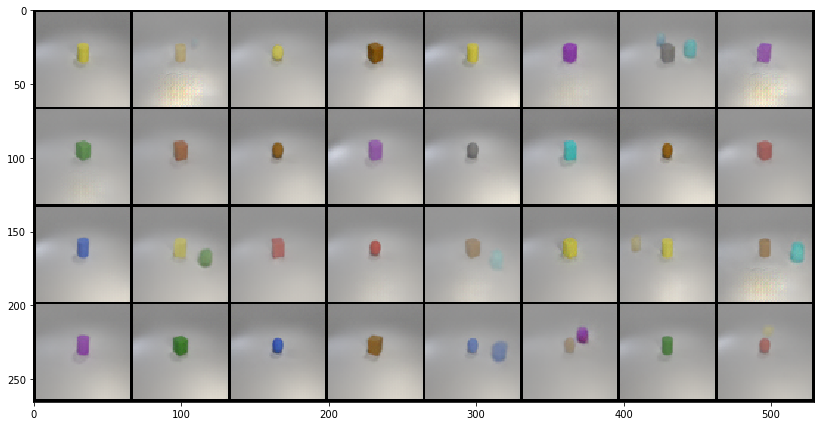

[Epoch 10/100] [D loss: 0.284482] [G loss: 0.812121] [test score: 0.097222]
[Epoch 11/100] [D loss: 0.273316] [G loss: 0.809877] [test score: 0.125000]
[Epoch 12/100] [D loss: 0.298700] [G loss: 0.711646] [test score: 0.111111]
[Epoch 13/100] [D loss: 0.296618] [G loss: 0.688295] [test score: 0.111111]
[Epoch 14/100] [D loss: 0.288458] [G loss: 0.710559] [test score: 0.138889]
[Epoch 15/100] [D loss: 0.273217] [G loss: 0.796093] [test score: 0.111111]
[Epoch 16/100] [D loss: 0.282146] [G loss: 0.736229] [test score: 0.111111]
[Epoch 17/100] [D loss: 0.278307] [G loss: 0.709116] [test score: 0.125000]
[Epoch 18/100] [D loss: 0.311598] [G loss: 0.601669] [test score: 0.125000]
[Epoch 19/100] [D loss: 0.285638] [G loss: 0.650470] [test score: 0.125000]


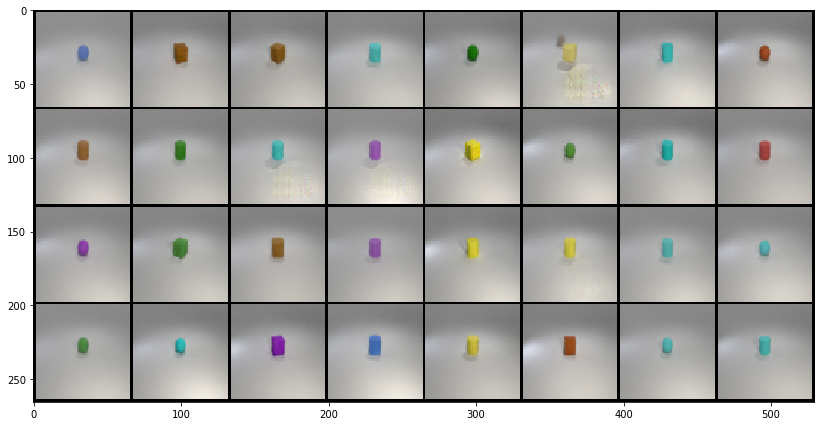

[Epoch 20/100] [D loss: 0.281645] [G loss: 0.670357] [test score: 0.125000]
[Epoch 21/100] [D loss: 0.282386] [G loss: 0.666663] [test score: 0.111111]
[Epoch 22/100] [D loss: 0.274121] [G loss: 0.700616] [test score: 0.111111]
[Epoch 23/100] [D loss: 0.294363] [G loss: 0.596211] [test score: 0.125000]
[Epoch 24/100] [D loss: 0.321459] [G loss: 0.571313] [test score: 0.125000]
[Epoch 25/100] [D loss: 0.293257] [G loss: 0.566094] [test score: 0.111111]
[Epoch 26/100] [D loss: 0.276747] [G loss: 0.638322] [test score: 0.111111]
[Epoch 27/100] [D loss: 0.282935] [G loss: 0.614856] [test score: 0.125000]
[Epoch 28/100] [D loss: 0.280210] [G loss: 0.622235] [test score: 0.138889]
[Epoch 29/100] [D loss: 0.279065] [G loss: 0.625768] [test score: 0.125000]


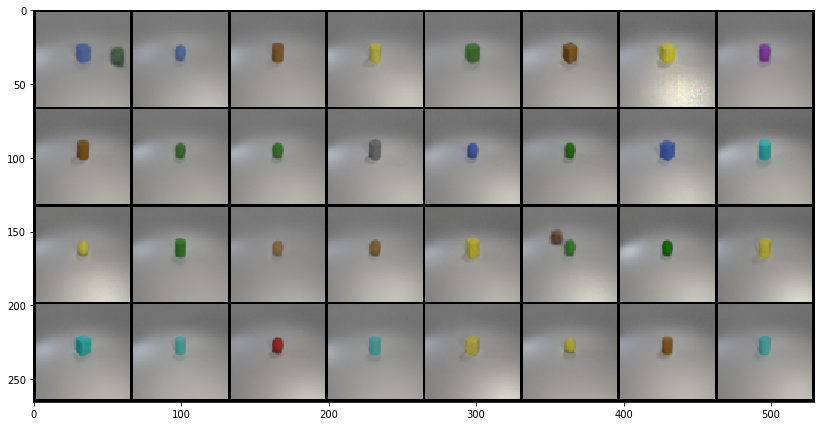

[Epoch 30/100] [D loss: 0.282871] [G loss: 0.603439] [test score: 0.111111]
[Epoch 31/100] [D loss: 0.286205] [G loss: 0.573061] [test score: 0.125000]
[Epoch 32/100] [D loss: 0.277508] [G loss: 0.589070] [test score: 0.125000]
[Epoch 33/100] [D loss: 0.283123] [G loss: 0.582459] [test score: 0.125000]
[Epoch 34/100] [D loss: 0.277462] [G loss: 0.592136] [test score: 0.125000]
[Epoch 35/100] [D loss: 0.286963] [G loss: 0.569524] [test score: 0.125000]
[Epoch 36/100] [D loss: 0.280870] [G loss: 0.558374] [test score: 0.125000]
[Epoch 37/100] [D loss: 0.282449] [G loss: 0.567885] [test score: 0.125000]
[Epoch 38/100] [D loss: 0.281226] [G loss: 0.564164] [test score: 0.125000]
[Epoch 39/100] [D loss: 0.280551] [G loss: 0.559815] [test score: 0.125000]


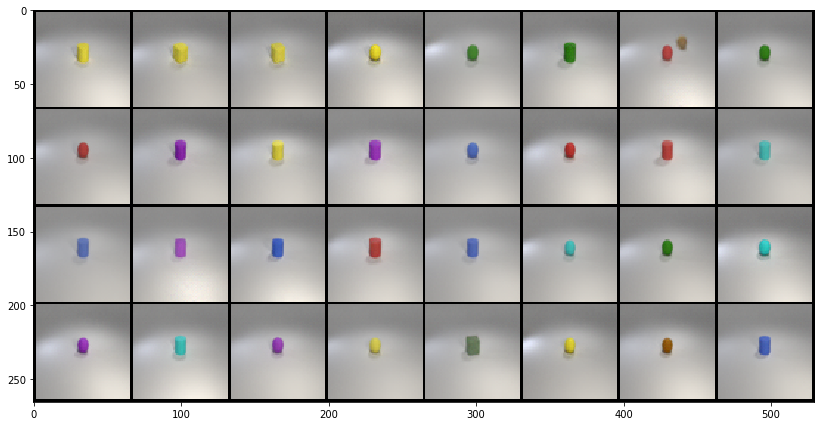

[Epoch 40/100] [D loss: 0.286479] [G loss: 0.534893] [test score: 0.125000]
[Epoch 41/100] [D loss: 0.272859] [G loss: 0.589924] [test score: 0.125000]
[Epoch 42/100] [D loss: 0.284407] [G loss: 0.548193] [test score: 0.125000]


KeyboardInterrupt: 

In [6]:
# training 
epochs = 100
n_critic = 1 # number of training steps for discriminator per iter
save = True
g_loss_list = []
d_loss_list = []
max_g_loss = np.inf
max_d_loss = np.inf

FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor

for epoch in tqdm.notebook.tqdm(range(epochs)):
    total_d_loss = 0
    total_g_loss = 0
    generator.train()
    
    for i, (real_imgs, labels) in enumerate(train_loader):
        batch_size = real_imgs.shape[0]

        real_imgs = real_imgs[:, :3].to(device)
        real_labels = labels.to(device)
        
        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device) # shape [batch_size, latent_dim] with normal distribution
#         gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, (batch_size, 1)))) # shape [batch_size, 1] with 0~24
#         one_hot =  np.zeros((batch_size, n_classes))
#         one_hot[np.arange(batch_size), gen_labels] = 1
#         gen_labels = torch.from_numpy(one_hot).to(device)        
        
        # Generate a batch of images
        gen_imgs = generator(z, real_labels) # shape [batch_size, 3, 64, 64]
        
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

         # Real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + \
                       auxiliary_loss(real_aux, real_labels.float())) / 2
                
        # Fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, real_labels.float())) / 2

         # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        # Train the generator every n_critic steps
        if i % n_critic == 0:
            optimizer_G.zero_grad()

            # Loss measures generator's ability to fool the discriminator
            gen_imgs = generator(z, real_labels) # shape [batch_size, 3, 64, 64]
            
            # Loss measures generator's ability to fool the discriminator
            fake_validity, pred_label = discriminator(gen_imgs)
                        
#             g_loss = -torch.mean(fake_validity)
            g_loss = 0.5 * (adversarial_loss(fake_validity, valid) + auxiliary_loss(pred_label, real_labels.float()))

            g_loss.backward()
            optimizer_G.step()
        
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()

    # loss save
    if save:
        save_acc(path+"loss.npz", total_g_loss, total_d_loss)
    else:
        g_loss_list.append(total_g_loss)
        d_loss_list.append(total_d_loss)

    total_d_loss /= len(train_loader)
    total_g_loss /= (len(train_loader)/n_critic)
    g_loss_list.append(total_g_loss)
    d_loss_list.append(total_d_loss)
    
    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f] [test score: %f]"
        % (epoch+1, epochs, total_d_loss, total_g_loss, test_eval(generator, epoch+1))
    )

    if save:
        if max_g_loss > total_g_loss:
            max_g_loss = total_g_loss
            torch.save(generator, path+"generator.pt")
        if max_d_loss > total_d_loss:
            max_d_loss = total_d_loss
            torch.save(discriminator, path+"discriminator.pt")

In [ ]:
plt.figure(figsize=(14, 8))

load = True
if load:
    acc = np.load(path+"loss.npz")
    g_loss = acc['g_loss']
    d_loss = acc['d_loss']

# plt.title("Activation Function comparision(EEGNet)", fontsize=18)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
x = np.arange(1, len(g_loss)+1)
plt.plot(x, g_loss, label="g_loss")
plt.plot(x, d_loss, label="d_loss")
plt.legend()
plt.show()

In [ ]:
## evaluate
# generator = torch.load("./Auxiliary_DCGAN_generator.pt", map_location=device)
# generator.eval()

print(test_eval(generator, 0))

In [ ]:
eval_model = evaluation_model()
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    out = F.interpolate(images, size=64)  #The resize operation on tensor.
    print(out.shape)
    print(eval_model.eval(images[:, :3], labels))
#     grid = make_grid(out)
    break

In [ ]:
img, label = train.__getitem__(0)
 # step 1: convert it to [0 ,2]
img = img +1

 # step 2: convert it to [0 ,1]
img = img - img.min()
img = img / (img.max() - img.min())

print(img.shape)
plt.imshow(np.transpose(img,(1,2,0)))

In [ ]:
auxiliary_loss = nn.BCELoss()
# Loss measures generator's ability to fool the discriminator
gen_imgs = generator(z, real_labels)

# Loss measures generator's ability to fool the discriminator
fake_validity, pred_label = discriminator(gen_imgs)

g_loss_fake = -torch.mean(fake_validity)
g_loss_cls = auxiliary_loss(pred_label, real_labels.float())
g_loss = g_loss_fake + lambda_cls * g_loss_cls